In [1]:
import pandas as pd

import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.python.keras.models import load_model, Model,Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import autocorrelation_plot
from livelossplot.inputs.tf_keras import PlotLossesCallback


import seaborn as sns #https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b  because of the dataset size
import statsmodels.api as sm
from pandas.plotting import scatter_matrix

from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
#import lightgbm as lgb

import cv2
from PIL import Image
import pickle


In [2]:
import os 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


In [3]:
print(device_lib.list_local_devices())
print("Num GPUs Available: ", (tf.config.experimental.list_physical_devices()))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17150009803519288010
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6900923776
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1405108652856325882
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
]
Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPU


In [4]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
SAVING_INCORRECT = False

In [5]:
sample_submission = pd.read_csv("./sample_submission.csv")
test = test.merge(sample_submission, left_index=True, right_index=True)
test_col= test.columns.tolist()
test_col.remove("ImageId")
test_col.insert(0, "ImageId")
test = test[test_col]
test.head()
del sample_submission

In [6]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
np.sort(train.label.unique().tolist())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<AxesSubplot:>

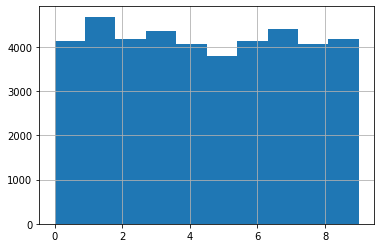

In [8]:
train.label.hist()

In [9]:
np.sort(test.Label.unique().tolist())

array([0])

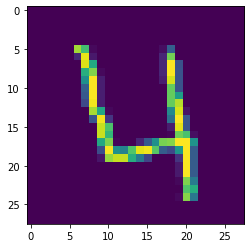

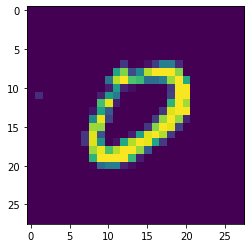

In [10]:
def get_image_list(images,img_size,TRAIN):
    X = []
    Y = []
    for i in images.values:
        if TRAIN:
            X.append(i[1:].reshape((img_size,img_size)))
            Y.append(i[0])
        else:
            X.append(i[1:-1].reshape((img_size,img_size)))
            Y.append(i[-1])
    
    return X,Y
    
X,Y = get_image_list(train,int(np.sqrt(len(train.columns)- 1)), TRAIN=True)
X_test,Y_test = get_image_list(test,int(np.sqrt(len(test.columns)- 2)), TRAIN=False)

plt.figure()
plt.imshow(X[3])

plt.figure()
plt.imshow(X_test[3])

plt.show()

## Rotate, crop, RGB Experiments

(28, 28)
(28, 28, 3)


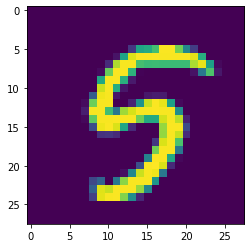

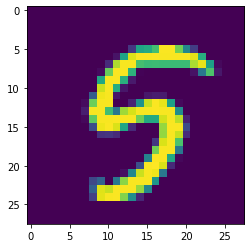

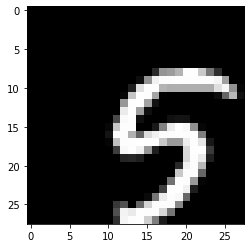

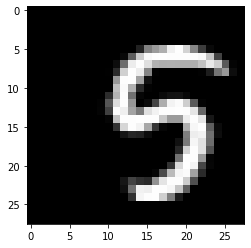

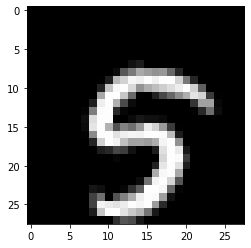

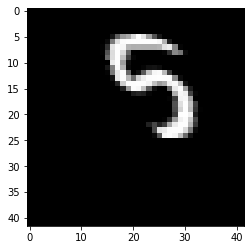

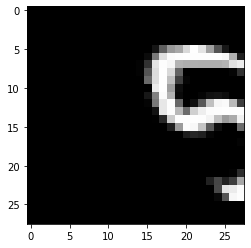

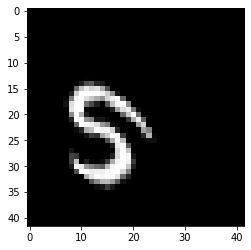

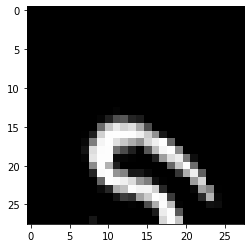

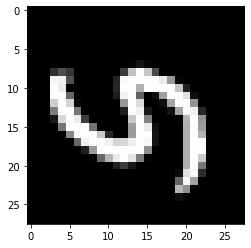

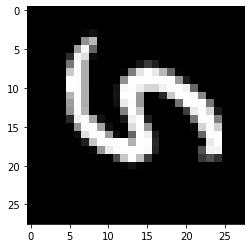

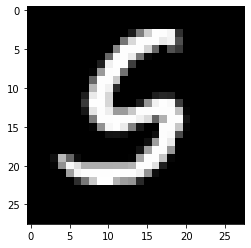

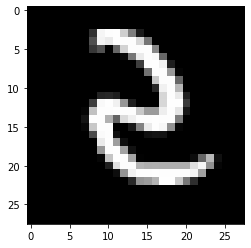

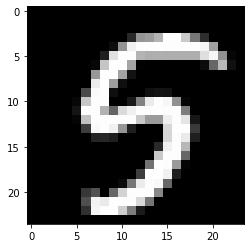

In [11]:
img = X[8]
plt.figure()
plt.imshow(img)

img = Image.fromarray((img).astype(np.uint8)).convert('L')
plt.figure()
img = np.asarray(img)
plt.imshow(img)
print(img.shape)

img = Image.fromarray((img).astype(np.uint8)).convert('RGB')
plt.figure()
img = np.asarray(img)
plt.imshow(img)
print(img.shape)


rows, cols, dim = img.shape
#**********IMAGE TRANSLATION*****************
# transformation matrix for translation
M = np.float32([[1, 0, 3],
                [0, 1, 3],
                [0, 0, 1]])
# apply a perspective transformation to the image
translated_img = cv2.warpPerspective(img, M, (cols, rows))
plt.imshow(translated_img)


plt.figure()
# transformation matrix for translation
M = np.float32([[1, 0.2, 0.2],
                [0, 1, 0],
                [0, 0, 1]])
# apply a perspective transformation to the image
translated_img = cv2.warpPerspective(img, M, (cols, rows))
plt.imshow(translated_img)

plt.figure()
# transformation matrix for translation
M = np.float32([[1, 0, 0],
                [0.2, 1, 0],
                [0, 0, 1]])
# apply a perspective transformation to the image
translated_img = cv2.warpPerspective(img, M, (cols, rows))
plt.imshow(translated_img)


#**********IMAGE SHEARING X AXIS*****************
plt.figure()
M = np.float32([[1, 0.7, 0],
             	[0, 1  , 0],
            	[0, 0  , 1]])
# apply a perspective transformation to the image                
sheared_img = cv2.warpPerspective(img,M,(int(cols*1.5),int(rows*1.5)))
plt.imshow(sheared_img)
plt.figure()
sheared_img = cv2.warpPerspective(img,M,(int(cols),int(rows)))
plt.imshow(sheared_img)


#**********IMAGE SHEARING Y AXIS*****************
plt.figure()
M = np.float32([[1,   0, 0],
             	[0.7, 1, 0],
             	[0,   0, 1]])
# apply a perspective transformation to the image                
sheared_img = cv2.warpPerspective(img,M,(int(cols*1.5),int(rows*1.5)))
plt.imshow(sheared_img)

plt.figure()
sheared_img = cv2.warpPerspective(img,M,(int(cols),int(rows)))
plt.imshow(sheared_img)  

#**********IMAGE ROTATION*****************
plt.figure()
img_rotate_90_clockwise = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(img_rotate_90_clockwise)

plt.figure()
img_rotate_90_counterclockwise  = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imshow(img_rotate_90_counterclockwise )

plt.figure()
img_rotate_180  = cv2.rotate(img, cv2.ROTATE_180)
plt.imshow(img_rotate_180 )

plt.figure()
img_flip_ud = cv2.flip(img, 0)
plt.imshow(img_flip_ud )

plt.figure()
cropped_image = img[2:26, 2:26] # top vertical:botton vertical , left horizontal : right horizontal
plt.imshow(cropped_image)



In [12]:
ix=img[...,np.newaxis]
ix.shape

(28, 28, 3, 1)

In [13]:
def data_aug(Inputs, Outputs, TRAIN):
    X_temp = []
    Y_temp = []
    for i in range(len(Inputs)):
        img= Inputs[i]
        #img = img[2:26, 2:26]

        img = Image.fromarray((img).astype(np.uint8)).convert('RGB') # Convert to RGB to be black/wite and dim W,H,C
        img = np.asarray(img) # Convert back to array
        X_temp.append(img)
        Y_temp.append(Outputs[i])
        
        if TRAIN:
            #**********IMAGE ROTATION*****************
            #if Outputs[i] != 6 and Outputs[i] != 9:
            
            """if Outputs[i] != 6 and Outputs[i] != 9:
                X_temp.append(cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))
                Y_temp.append(Outputs[i])

                X_temp.append(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
                Y_temp.append(Outputs[i])

                X_temp.append(cv2.rotate(img, cv2.ROTATE_180))
                Y_temp.append(Outputs[i])
            
            if Outputs[i] != 2 and Outputs[i] != 5:
                X_temp.append(cv2.flip(img, 0))
                Y_temp.append(Outputs[i])"""
            
            #**********IMAGE TRANSLATION*****************
            rows, cols, dim = img.shape
            # transformation matrix for translation
            M = np.float32([[1, 0, 3],
                            [0, 1, 3],
                            [0, 0, 1]])
            # apply a perspective transformation to the image
            X_temp.append(cv2.warpPerspective(img, M, (cols, rows)))
            Y_temp.append(Outputs[i])
            
            # transformation matrix for translation
            M = np.float32([[1, 0.2, 0.2],
                            [0, 1, 0],
                            [0, 0, 1]])
            # apply a perspective transformation to the image
            X_temp.append(cv2.warpPerspective(img, M, (cols, rows)))
            Y_temp.append(Outputs[i])

            # transformation matrix for translation
            M = np.float32([[1, 0, 0],
                            [0.2, 1, 0],
                            [0, 0, 1]])
            # apply a perspective transformation to the image
            X_temp.append(cv2.warpPerspective(img, M, (cols, rows)))
            Y_temp.append(Outputs[i])
            
            
            #**********IMAGE SHEARING X AXIS*****************
            M = np.float32([[1, 0.7, 0],
                            [0, 1  , 0],
                            [0, 0  , 1]])
            # apply a perspective transformation to the image  
            image_tmp = cv2.warpPerspective(img,M,(int(cols),int(rows)))
         
            X_temp.append(image_tmp)
            Y_temp.append(Outputs[i])


            #**********IMAGE SHEARING Y AXIS*****************
            M = np.float32([[1,   0, 0],
                            [0.7, 1, 0],
                            [0,   0, 1]])
            # apply a perspective transformation to the image                
            X_temp.append(cv2.warpPerspective(img,M,(int(cols),int(rows))))
            Y_temp.append(Outputs[i])

        """for i in [2,4,6]:
            img = img[i:26, 0:27] # Crop
            X_temp.append(img)

            img = img[0:27, i:27] # Crop
            X_temp.append(img)

            img = img[0:26-i, 0:27] # Crop
            X_temp.append(img)

            img = img[0:27, 0:27-i] # Crop
            X_temp.append(img)"""


    print(len(Inputs),"--->",len(X_temp),len(Y_temp))
    return X_temp,Y_temp

X,Y = data_aug(X, Y, True)
X_test,Y_test = data_aug(X_test, Y_test,False)

42000 ---> 252000 252000
28000 ---> 28000 28000


In [14]:
if SAVING_INCORRECT == False:
    with open('incorrect.pickle', 'rb') as handle:
        incorrect = pickle.load(handle)

In [15]:
len(incorrect)

131

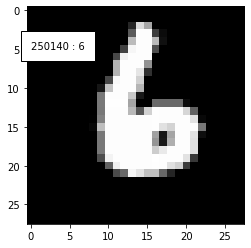

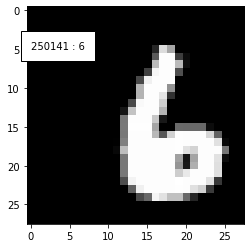

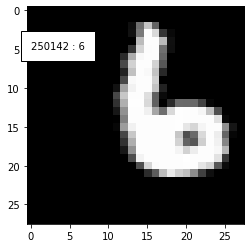

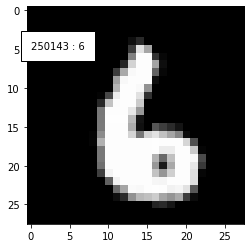

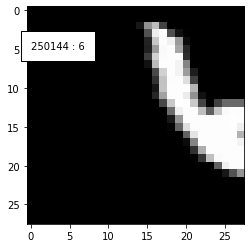

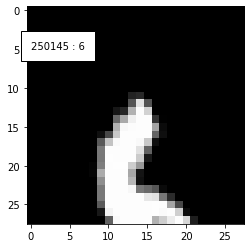

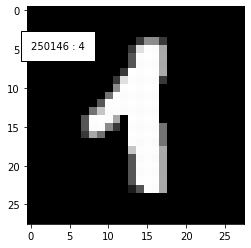

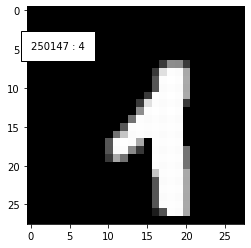

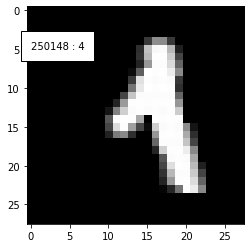

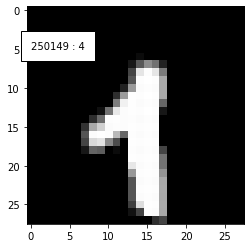

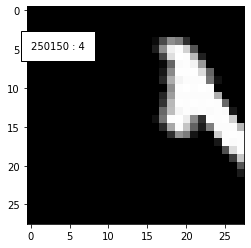

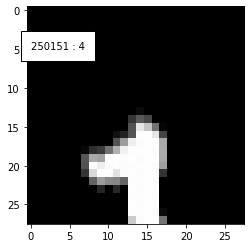

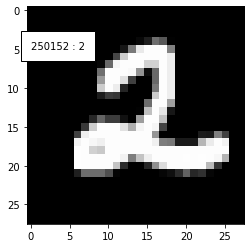

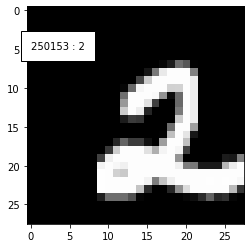

In [16]:
for ind in range(250146-6,250146+8):

    fig, ax = plt.subplots(1)
    img = X[ind]
    ax.imshow(img)
    
    leg = str(ind)+" : "+str(Y[ind])
    ax.text(0,5,leg, bbox={'facecolor': 'white', 'pad': 10})
    plt.show()
    

In [17]:
"""for ind in reversed(range(240372,240377+1)):
    Y[ind]=7
    if ind in incorrect:
        incorrect.remove(ind)"""

for ind in reversed(range(250146,250151+1)):
    Y[ind]=1
    if ind in incorrect:
        incorrect.remove(ind)

In [18]:
to_remove_list= sorted(list(range(239940,239945+1)) +list(range(242838,242843+1))+ list(range(245208,245213+1))+[251782,251783,250756,241336,241337,241432,241433,241480,241481,241547,241996,242128,242129,243065,244055,244799,245543,245639,246406,246407,247331,247666,248152,248153,248254,248255,248957,249760,249761])
to_remove_list

[239940,
 239941,
 239942,
 239943,
 239944,
 239945,
 241336,
 241337,
 241432,
 241433,
 241480,
 241481,
 241547,
 241996,
 242128,
 242129,
 242838,
 242839,
 242840,
 242841,
 242842,
 242843,
 243065,
 244055,
 244799,
 245208,
 245209,
 245210,
 245211,
 245212,
 245213,
 245543,
 245639,
 246406,
 246407,
 247331,
 247666,
 248152,
 248153,
 248254,
 248255,
 248957,
 249760,
 249761,
 250756,
 251782,
 251783]

In [19]:
"""for ind in to_remove_list:

    fig, ax = plt.subplots(1)
    img = X[ind]
    ax.imshow(img)
    
    leg = str(ind)+" : "+str(Y[ind])
    ax.text(0,5,leg, bbox={'facecolor': 'white', 'pad': 10})
    plt.show()"""

'for ind in to_remove_list:\n\n    fig, ax = plt.subplots(1)\n    img = X[ind]\n    ax.imshow(img)\n    \n    leg = str(ind)+" : "+str(Y[ind])\n    ax.text(0,5,leg, bbox={\'facecolor\': \'white\', \'pad\': 10})\n    plt.show()'

In [20]:
for ind in reversed(to_remove_list):
    X.pop(ind)
    Y.pop(ind)
    if ind in incorrect:
        incorrect.remove(ind)

In [21]:
to_remove_list= sorted([1583,140936,166991,169745,201551,239765,241421,241828,242110,242111,245824,245825])
to_remove_list

[1583,
 140936,
 166991,
 169745,
 201551,
 239765,
 241421,
 241828,
 242110,
 242111,
 245824,
 245825]

In [22]:
for ind in reversed(to_remove_list):
    X.pop(ind)
    Y.pop(ind)
    if ind in incorrect:
        incorrect.remove(ind)

In [23]:
"""to_remove_list = [99591,239465,239759,240676,240892,240893,240940,241539,241700,241975,
                  242528,242834,242835,243715,243853,243854,243886,246056,246140,246431,
                  247283,247326,247327,247719,249323,249777,249788
                  247720]
to_remove_list= sorted(list(range(245813,245815+1)) +list(range(243886,243890+1)))#+ to_remove_list)
for ind in reversed(to_remove_list):
    X.pop(ind)
    Y.pop(ind)"""
    

'to_remove_list = [99591,239465,239759,240676,240892,240893,240940,241539,241700,241975,\n                  242528,242834,242835,243715,243853,243854,243886,246056,246140,246431,\n                  247283,247326,247327,247719,249323,249777,249788\n                  247720]\nto_remove_list= sorted(list(range(245813,245815+1)) +list(range(243886,243890+1)))#+ to_remove_list)\nfor ind in reversed(to_remove_list):\n    X.pop(ind)\n    Y.pop(ind)'

In [24]:
"""for ind in incorrect:

    fig, ax = plt.subplots(1)
    img = X[ind]
    ax.imshow(img)
    
    leg = str(ind)+" : "+str(Y[ind])
    ax.text(0,5,leg, bbox={'facecolor': 'white', 'pad': 10})
    plt.show()"""

'for ind in incorrect:\n\n    fig, ax = plt.subplots(1)\n    img = X[ind]\n    ax.imshow(img)\n    \n    leg = str(ind)+" : "+str(Y[ind])\n    ax.text(0,5,leg, bbox={\'facecolor\': \'white\', \'pad\': 10})\n    plt.show()'

In [25]:
"""if SAVING_INCORRECT == False:
    for i in incorrect:
        X.pop(i)
        Y.pop(i)
    print(len(X),len(X))"""

'if SAVING_INCORRECT == False:\n    for i in incorrect:\n        X.pop(i)\n        Y.pop(i)\n    print(len(X),len(X))'

In [26]:
X , Y =np.array(X),np.array(Y) 
X_test , Y_test =np.array(X_test),np.array(Y_test) 

In [27]:
W=X[0].shape[0]
H=X[0].shape[1]


In [28]:
"""model = Sequential()
model.add(layers.Conv2D(128, (6, 6), activation='relu', input_shape=(W, H, 3)))#128
model.add(layers.Conv2D(128, (6, 6), activation='relu', input_shape=(W, H, 3)))
model.add(layers.Conv2D(64, (6, 6), activation='relu', input_shape=(W, H, 3)))
#model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
#model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])"""#0.00005 IS THE RIGHT ONE

model = Sequential()
model.add(layers.Conv2D(64, (6, 6), activation='relu', input_shape=(W, H, 3)))#128
model.add(layers.Conv2D(128, (6, 6), activation='relu', input_shape=(W, H, 3)))
model.add(layers.Conv2D(256, (6, 6), activation='relu', input_shape=(W, H, 3)))
#model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
#model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])#0.00005 IS THE RIGHT ONE

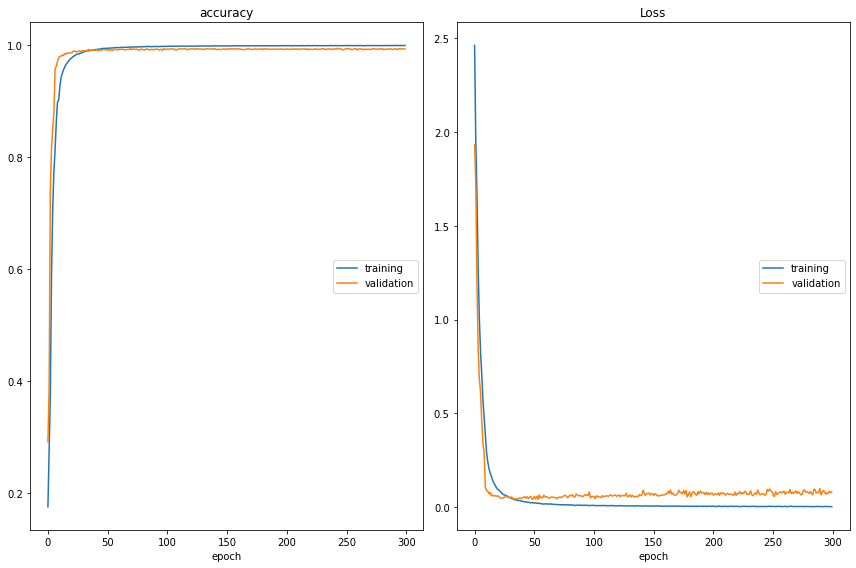

accuracy
	training         	 (min:    0.175, max:    0.999, cur:    0.999)
	validation       	 (min:    0.292, max:    0.994, cur:    0.993)
Loss
	training         	 (min:    0.002, max:    2.462, cur:    0.003)
	validation       	 (min:    0.042, max:    1.932, cur:    0.081)


In [29]:
model.fit(X,Y,validation_split= 0.05, 
          epochs= 300, batch_size = 1024, callbacks=[PlotLossesCallback()])#1024

In [30]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(X)
Y_pred = np.argmax(Y_pred, axis= 1)

confusion_matrix(list(Y),list(Y_pred))

array([[24787,     0,     0,     0,     0,     0,     1,     0,     2,
            0],
       [    0, 28103,     0,     0,     0,     0,     0,     7,     0,
            0],
       [    1,     1, 25039,     3,     0,     0,     0,     2,     5,
            0],
       [    2,     0,     3, 26096,     0,     0,     2,     0,     1,
            0],
       [    0,     0,     0,     0, 24414,     0,     2,     0,     2,
            4],
       [    0,     0,     0,     3,     0, 22758,     2,     0,     4,
            0],
       [    0,     0,     0,     0,     0,     0, 24822,     0,     0,
            0],
       [    0,     0,     6,     4,     0,     0,     0, 26393,     0,
            0],
       [    0,     0,     0,     2,    10,     2,     3,     0, 24335,
            0],
       [    2,     0,     4,     1,     8,     0,     1,     0,     2,
        25102]])

In [31]:
incorrect=[]
Y_list = list(Y)
Y_hat_list = list(Y_pred)
for i in range(len(Y_hat_list)):
    if Y_list[i] != Y_hat_list[i]:
        #if Y_list[i] != 6 and Y_list[i] != 9 :#and Y_list[i] != 2 and Y_list[i] != 5:
        incorrect.append(i)

In [32]:
len(incorrect)

92

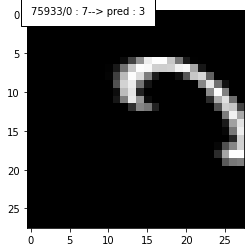

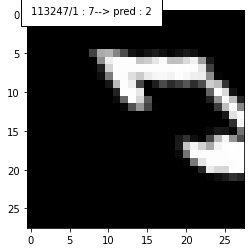

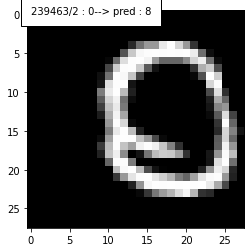

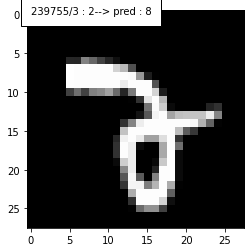

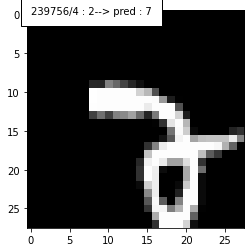

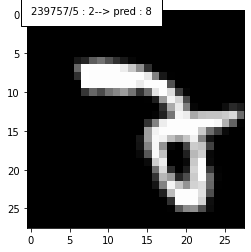

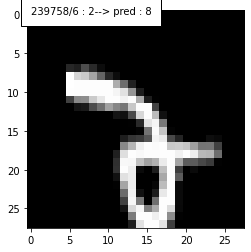

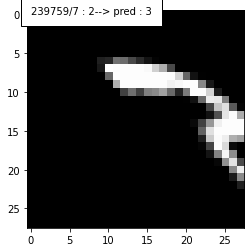

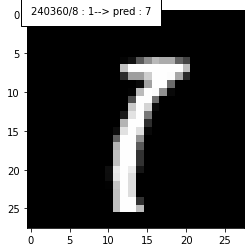

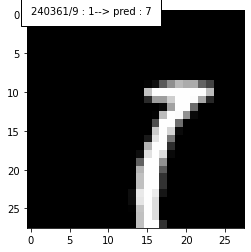

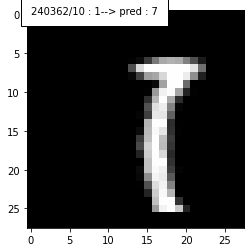

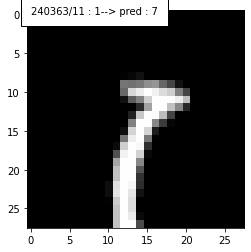

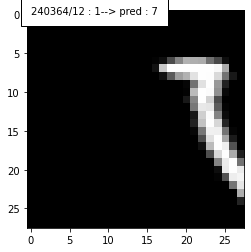

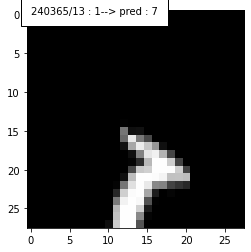

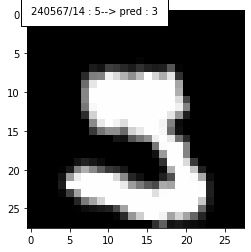

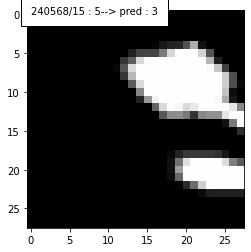

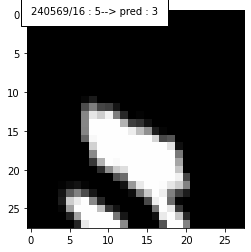

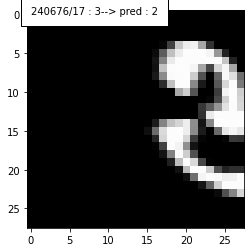

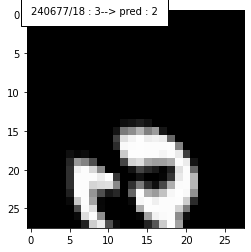

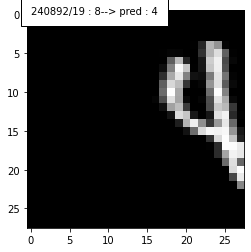

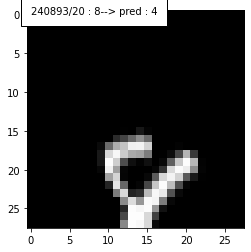

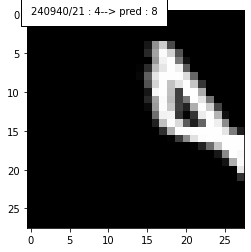

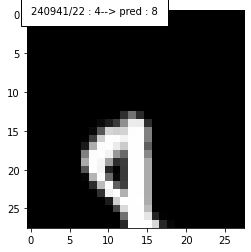

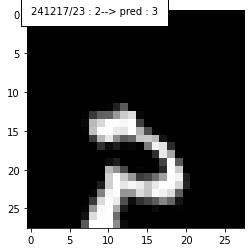

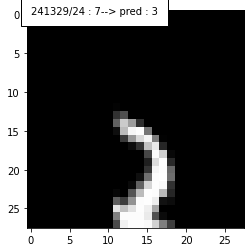

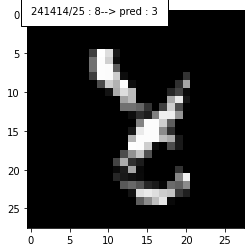

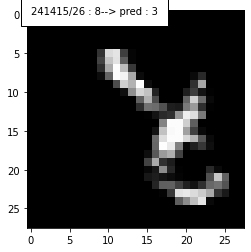

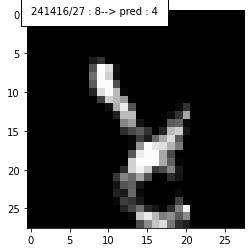

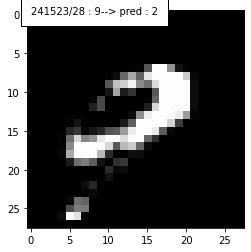

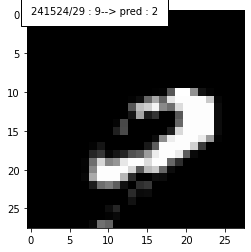

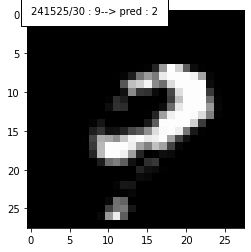

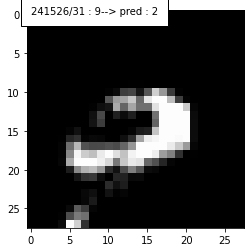

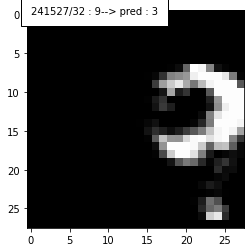

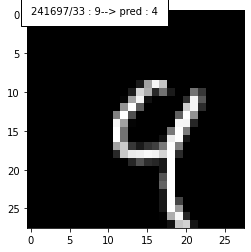

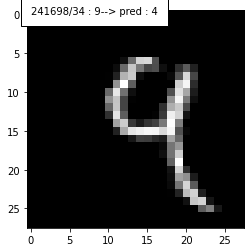

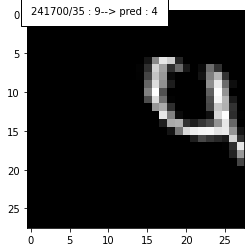

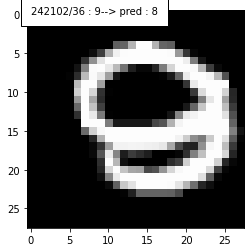

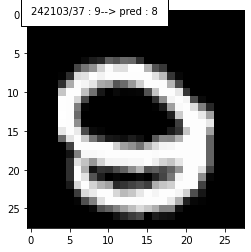

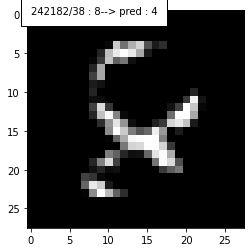

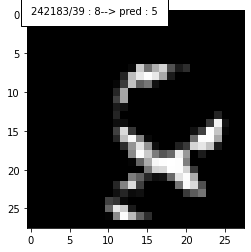

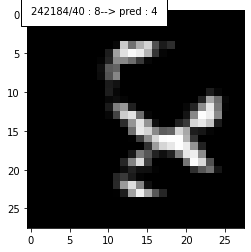

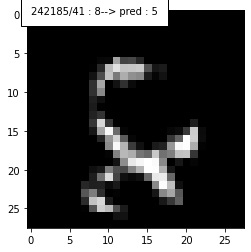

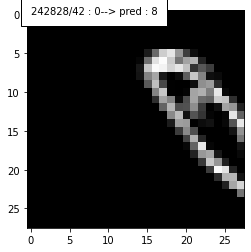

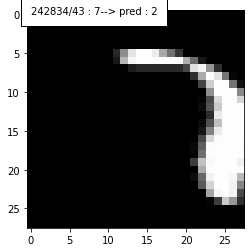

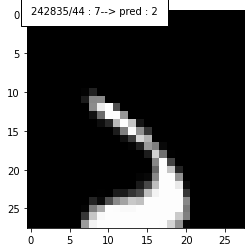

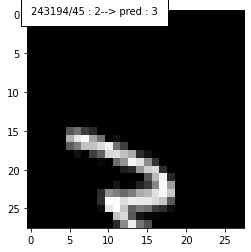

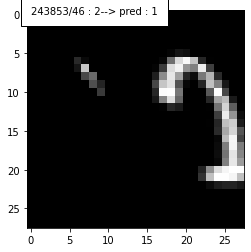

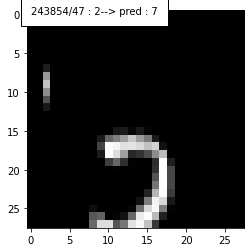

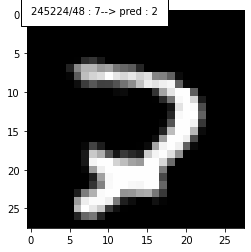

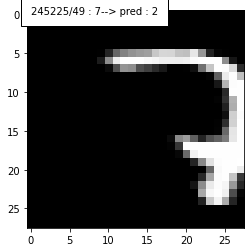

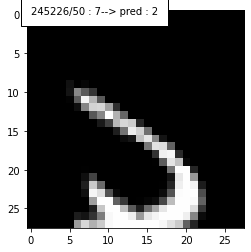

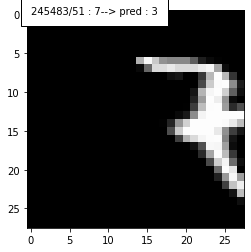

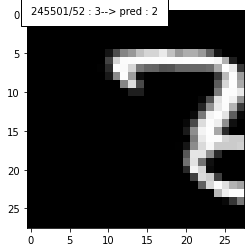

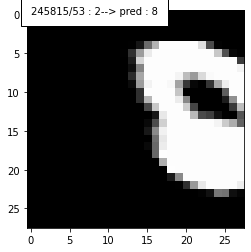

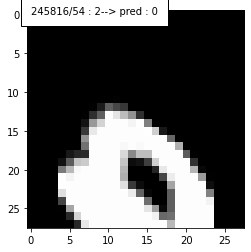

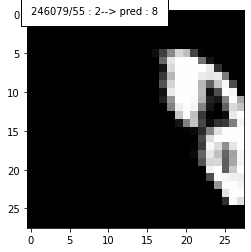

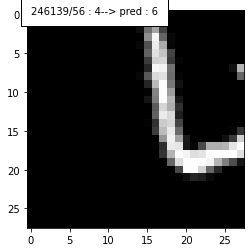

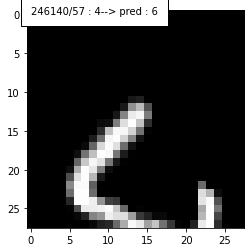

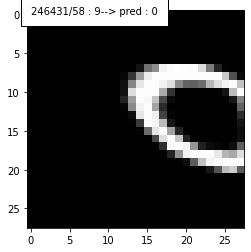

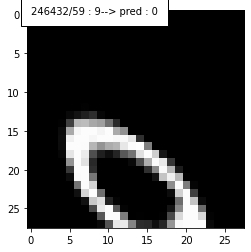

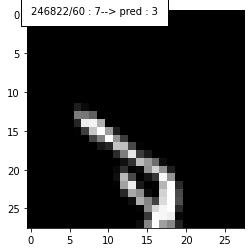

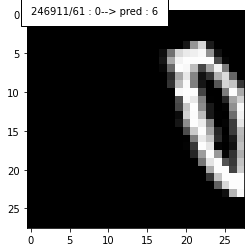

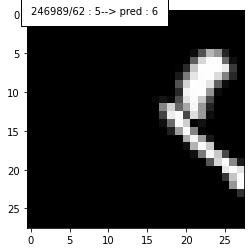

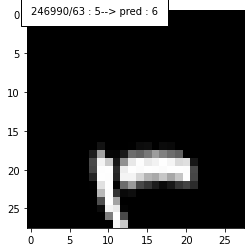

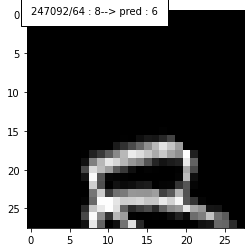

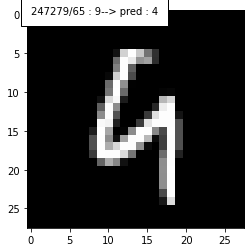

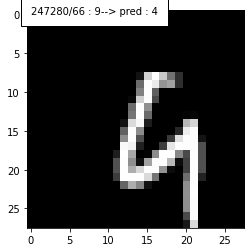

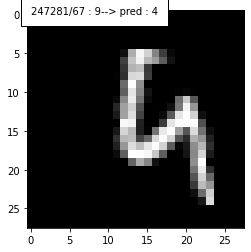

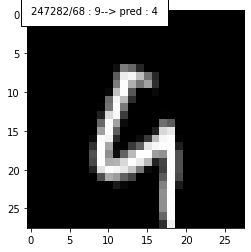

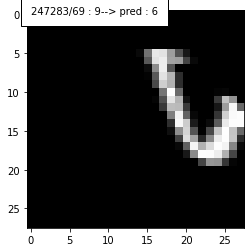

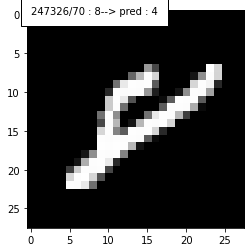

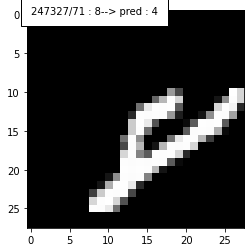

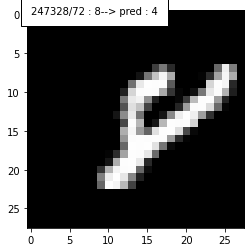

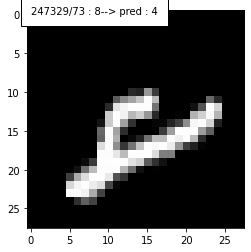

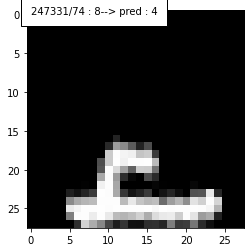

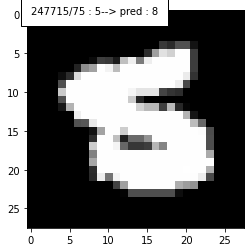

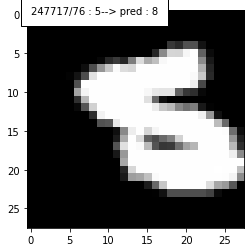

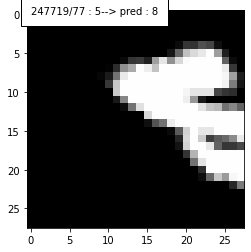

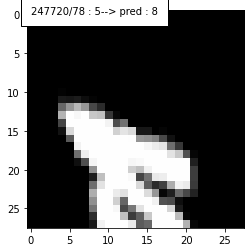

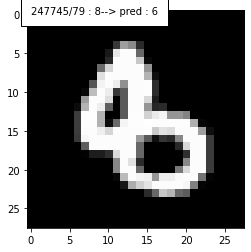

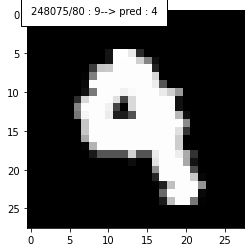

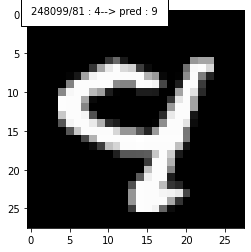

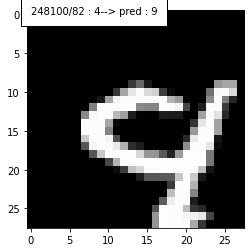

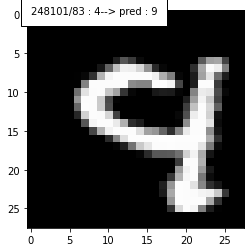

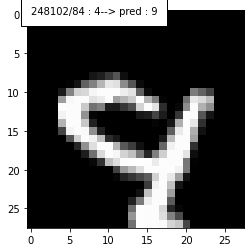

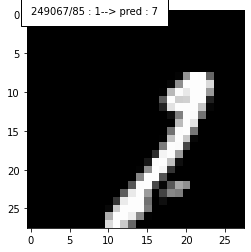

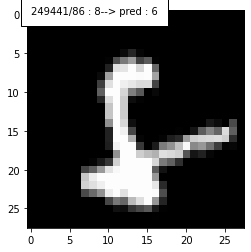

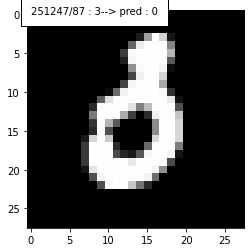

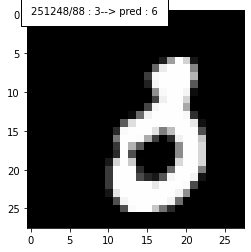

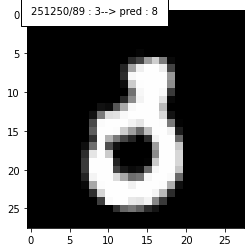

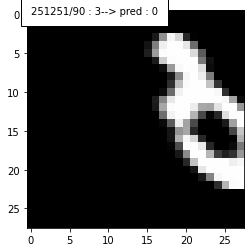

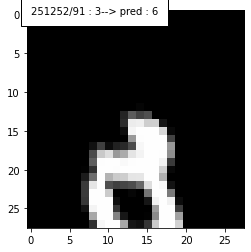

In [33]:
index = 0
for ind in incorrect:
    
    fig, ax = plt.subplots(1)
    img = X[ind]
    ax.imshow(img)
    
    leg = str(ind)+"/"+str(index)+" : "+str(Y_list[ind])+"--> pred : "+str(Y_hat_list[ind])
    ax.text(0,0,leg, bbox={'facecolor': 'white', 'pad': 10})
    plt.show()
    
    index +=1
    

In [34]:
"""for ind in range(incorrect[122]-6,incorrect[122]+12):

    fig, ax = plt.subplots(1)
    img = X[ind]
    ax.imshow(img)
    
    leg = str(ind)+" : "+str(Y_list[ind])+"--> pred : "+str(Y_hat_list[ind])
    ax.text(0,5,leg, bbox={'facecolor': 'white', 'pad': 10})
    plt.show()"""
    

'for ind in range(incorrect[122]-6,incorrect[122]+12):\n\n    fig, ax = plt.subplots(1)\n    img = X[ind]\n    ax.imshow(img)\n    \n    leg = str(ind)+" : "+str(Y_list[ind])+"--> pred : "+str(Y_hat_list[ind])\n    ax.text(0,5,leg, bbox={\'facecolor\': \'white\', \'pad\': 10})\n    plt.show()'

In [35]:
"""img = X[5690]

plt.figure()
img_rotate_180  = cv2.rotate(img, cv2.ROTATE_180)
plt.imshow(img_rotate_180 )

plt.figure()
img_flip_ud = cv2.flip(img, 0)
plt.imshow(img_flip_ud )

plt.figure()
img_flip_ud = cv2.flip(img_flip_ud, 0)
plt.imshow(img_flip_ud )"""

'img = X[5690]\n\nplt.figure()\nimg_rotate_180  = cv2.rotate(img, cv2.ROTATE_180)\nplt.imshow(img_rotate_180 )\n\nplt.figure()\nimg_flip_ud = cv2.flip(img, 0)\nplt.imshow(img_flip_ud )\n\nplt.figure()\nimg_flip_ud = cv2.flip(img_flip_ud, 0)\nplt.imshow(img_flip_ud )'

0


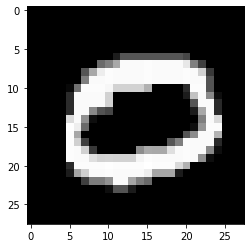

9


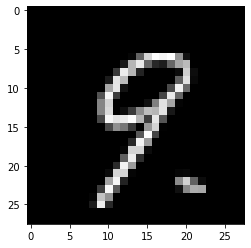

9


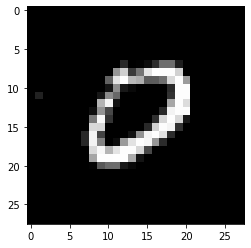

5


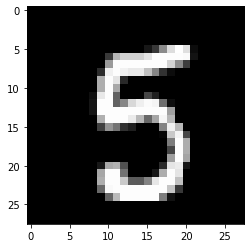

6


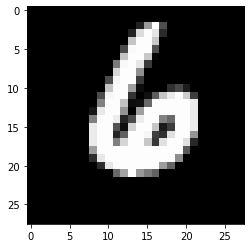

6


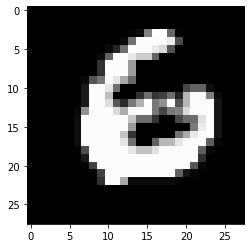

3


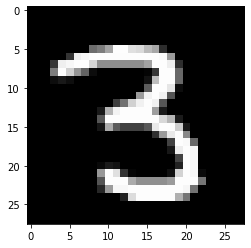

In [36]:
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis= 1)

for i in [1,2,3,10,50,500,2500]:
    plt.figure()
    Y_pred.shape
    print(Y_pred[i])
    plt.imshow(X_test[i])
    plt.show()   

In [37]:
Y_pred.shape

(28000,)

In [38]:
sample_submission = pd.read_csv("./sample_submission.csv")
sample_submission = sample_submission.set_index("ImageId")
sample_submission

,Label
ImageId,
1,0
2,0
3,0
4,0
5,0
...,...
27996,0
27997,0
27998,0


In [39]:
sample_submission["Label"] = Y_pred
np.sort(sample_submission.Label.unique().tolist())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [40]:
sample_submission.to_csv("digit_submission.csv")

In [41]:
if SAVING_INCORRECT:
    with open('incorrect.pickle', 'wb') as handle:
        pickle.dump(incorrect, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 

In [42]:
with open('incorrect2.pickle', 'wb') as handle:
        pickle.dump(incorrect, handle, protocol=pickle.HIGHEST_PROTOCOL)